In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import reduce
from matplotlib import colors
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler

# plotting params
%matplotlib inline
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['figure.figsize'] = (13.0, 6.0)
sns.set_style("white")

data_dir = './data/'
plot_dir = './imgs/'
dump_dir = './dump/'

## Setup

In [2]:
# ensuring reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = False

In [3]:
GPU = False

device = torch.device("cuda" if GPU else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if GPU else {}

## Data Loader

We need to create a special dataloader for the experiment with shuffling. This is necessary because we need to keep track of each sample and shuffling loses that information.

To solve this, we can:

- create permutations of a list of numbers from 0 to 59,999 (the number of images in MNIST)
- create a sampler class that takes a list and interates over it sequentially
- at each epoch, create a dataloader with a sampler that gets fed the precomputed permutations

In [4]:
class LinearSampler(Sampler):
    def __init__(self, idx):
        self.idx = idx

    def __iter__(self):
        return iter(self.idx)

    def __len__(self):
        return len(self.idx)

In [5]:
def get_data_loader(data_dir, batch_size, permutation=None, num_workers=3, pin_memory=False):
    normalize = transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    transform = transforms.Compose([transforms.ToTensor(), normalize])
    dataset = MNIST(root=data_dir, train=True, download=True, transform=transform)
    
    sampler = None
    if permutation is not None:
        sampler = LinearSampler(permutation)

    loader = DataLoader(
        dataset, batch_size=batch_size,
        shuffle=False, num_workers=num_workers,
        pin_memory=pin_memory, sampler=sampler
    )

    return loader

## Model

In [6]:
class SmallConv(nn.Module):
    def __init__(self):
        super(SmallConv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        out = F.relu(F.max_pool2d(self.conv1(x), 2))
        out = F.relu(F.max_pool2d(self.conv2(out), 2))
        out = out.view(-1, 320)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)

## Utility Functions

In [7]:
def accuracy(predicted, ground_truth):
    predicted = torch.max(predicted, 1)[1]
    total = len(ground_truth)
    correct = (predicted == ground_truth).sum().double()
    acc = 100 * (correct / total)
    return acc.item()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    
    epoch_stats = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # forward pass
        output = model(data)
        acc = accuracy(output, target)
        
        # compute batch loss and gradient norm
        losses = F.nll_loss(output, target, reduction='none')
        indices = [batch_idx*train_loader.batch_size + i for i in range(len(data))]
        
        batch_stats = []
        for i, l in zip(indices, losses):
            batch_stats.append([i, l])
        epoch_stats.append(batch_stats)
            
        # take average loss
        loss = losses.mean()
        
        # backwards pass
        loss.backward()
        optimizer.step()
        
        if batch_idx % 25 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
100. * batch_idx / len(train_loader), loss.item(), acc))

    return epoch_stats

def percentage_split(seq, percentages):
    cdf = np.cumsum(percentages)
    assert np.allclose(cdf[-1], 1.0)
    stops = list(map(int, cdf * len(seq)))
    return [seq[a:b] for a, b in zip([0]+stops, stops)]

def bin_losses(all_epochs, num_quantiles=10):
    percentile_splits = []
    for epoch in all_epochs:
        # sort by decreasing loss
        sorted_loss_idx = sorted(
            range(len(epoch)), key=lambda k: epoch[k][1], reverse=True
        )
        
        # bin into 10 quantiles
        splits = percentage_split(sorted_loss_idx, [num_quantiles/100]*num_quantiles)
        
        percentile_splits.append(splits)

    return percentile_splits

## Without Shuffling

In [8]:
num_epochs = 5
learning_rate = 1e-3
mom = 0.99
batch_size = 64

In [9]:
torch.manual_seed(SEED)

# instantiate convnet
model = SmallConv().to(device)

# relu init
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_in')

# define optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=mom)

# instantiate data loader
train_loader = get_data_loader(data_dir, batch_size, None, **kwargs)

stats_no_shuffling = []
for epoch in range(1,  num_epochs+1):
    stats_no_shuffling.append(train(model, device, train_loader, optimizer, epoch))
pickle.dump(stats_no_shuffling, open(dump_dir + "no_shuffling.pkl", "wb"))

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.633006	Acc: 10.94%
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.619076	Acc: 48.44%
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.823937	Acc: 71.88%
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.598104	Acc: 79.69%
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.370156	Acc: 92.19%
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.533670	Acc: 81.25%
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.291023	Acc: 89.06%
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.611064	Acc: 82.81%
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.301691	Acc: 85.94%
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.171518	Acc: 96.88%
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.311606	Acc: 92.19%
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.311102	Acc: 90.62%
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.225483	Acc: 93.75%
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.140306	Acc: 93.75%
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.154456	Acc: 95.31%
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.203898	Acc: 93.75%
Train Epoch: 1 [25600/

Train Epoch: 4 [30400/60000 (51%)]	Loss: 0.011213	Acc: 100.00%
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.038986	Acc: 96.88%
Train Epoch: 4 [33600/60000 (56%)]	Loss: 0.011563	Acc: 100.00%
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.129776	Acc: 96.88%
Train Epoch: 4 [36800/60000 (61%)]	Loss: 0.034880	Acc: 98.44%
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.020573	Acc: 100.00%
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.011226	Acc: 100.00%
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.037513	Acc: 98.44%
Train Epoch: 4 [43200/60000 (72%)]	Loss: 0.058901	Acc: 98.44%
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.043138	Acc: 98.44%
Train Epoch: 4 [46400/60000 (77%)]	Loss: 0.187012	Acc: 93.75%
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.007739	Acc: 100.00%
Train Epoch: 4 [49600/60000 (83%)]	Loss: 0.029716	Acc: 100.00%
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.147594	Acc: 98.44%
Train Epoch: 4 [52800/60000 (88%)]	Loss: 0.112262	Acc: 96.88%
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.010896	Acc: 100.00%
T

## With Shuffling

In [10]:
num_epochs = 5
learning_rate = 1e-3
mom = 0.99
batch_size = 64

In [11]:
# create permutations
permutations = []
permutations.append(list(np.arange(60000)))

x = list(np.arange(60000))
np.random.seed(SEED)

for _ in range(num_epochs-1):
    np.random.shuffle(x)
    permutations.append(x.copy())
pickle.dump(permutations, open(dump_dir + "permutations.pkl", "wb"))

In [12]:
torch.manual_seed(SEED)

model = SmallConv().to(device)

# relu init
for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, mode='fan_in')

# define optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=mom)

stats_with_shuffling = []
for epoch in range(1,  num_epochs+1):
    train_loader = get_data_loader(data_dir, batch_size, permutations[epoch-1], **kwargs)
    stats_with_shuffling.append(train(model, device, train_loader, optimizer, epoch))
pickle.dump(stats_with_shuffling, open(dump_dir + "with_shuffling.pkl", "wb"))

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.633006	Acc: 10.94%
Train Epoch: 1 [1600/60000 (3%)]	Loss: 1.619076	Acc: 48.44%
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.823937	Acc: 71.88%
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.598104	Acc: 79.69%
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.370156	Acc: 92.19%
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.533670	Acc: 81.25%
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.291023	Acc: 89.06%
Train Epoch: 1 [11200/60000 (19%)]	Loss: 0.611064	Acc: 82.81%
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.301691	Acc: 85.94%
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.171518	Acc: 96.88%
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.311606	Acc: 92.19%
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.311102	Acc: 90.62%
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.225483	Acc: 93.75%
Train Epoch: 1 [20800/60000 (35%)]	Loss: 0.140306	Acc: 93.75%
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.154456	Acc: 95.31%
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.203898	Acc: 93.75%
Train Epoch: 1 [25600/

Train Epoch: 4 [30400/60000 (51%)]	Loss: 0.041674	Acc: 100.00%
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.203437	Acc: 95.31%
Train Epoch: 4 [33600/60000 (56%)]	Loss: 0.010256	Acc: 100.00%
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.102535	Acc: 93.75%
Train Epoch: 4 [36800/60000 (61%)]	Loss: 0.030967	Acc: 98.44%
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.050214	Acc: 96.88%
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.032882	Acc: 98.44%
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.174472	Acc: 98.44%
Train Epoch: 4 [43200/60000 (72%)]	Loss: 0.044490	Acc: 98.44%
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.052338	Acc: 98.44%
Train Epoch: 4 [46400/60000 (77%)]	Loss: 0.005276	Acc: 100.00%
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.009933	Acc: 100.00%
Train Epoch: 4 [49600/60000 (83%)]	Loss: 0.200144	Acc: 96.88%
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.048852	Acc: 98.44%
Train Epoch: 4 [52800/60000 (88%)]	Loss: 0.030278	Acc: 98.44%
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.054861	Acc: 98.44%
Trai

## Generate Quantiles - Shuffling ON

In [13]:
stats_with_shuffling = pickle.load(open(dump_dir + "with_shuffling.pkl", "rb"))
permutations = pickle.load(open(dump_dir + "permutations.pkl", "rb"))

In [14]:
# flatten the list for each epoch
stats_with_shuffling_flat = []
for stat in stats_with_shuffling:
    stats_with_shuffling_flat.append(
        [v for sublist in stat for v in sublist]
    )

In [15]:
# remap the indices based on the permutations list
for stat, perm in zip(stats_with_shuffling_flat, permutations):
    for i in range(len(stat)):
        stat[i][0] = perm[i]
        stat[i][1] = stat[i][1].item()

In [16]:
# resort in increasing index order
for i in range(len(stats_with_shuffling_flat)):
    stats_with_shuffling_flat[i] = sorted(stats_with_shuffling_flat[i], key=lambda x: x[0])

In [17]:
# get percentile splits for all 5 epochs
num_quantiles = 10
percentile_splits = bin_losses(stats_with_shuffling_flat, num_quantiles)

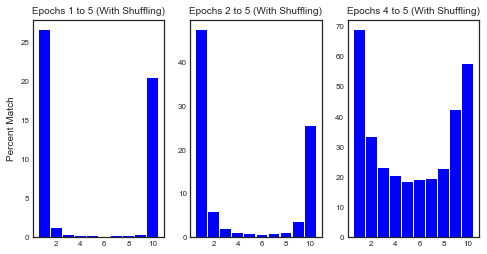

In [18]:
fr = [0, 1, 3]
to = [0, 0, 0]
names = ['1 to 5', '2 to 5', '4 to 5']

all_matches = []
for f, t in zip(fr, to):
    percent_matches = []
    for i in range(num_quantiles):
        percentile_all = []
        for j in range(f, len(percentile_splits)-t):
            percentile_all.append(percentile_splits[j][i])
        matching = reduce(np.intersect1d, percentile_all)
        percent = 100 * len(matching) / len(percentile_all[0])
        percent_matches.append(percent)
    all_matches.append(percent_matches)
    
        
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
for i, (ax, match, n) in enumerate(zip(axes, all_matches, names)):
    ax.bar(range(1, num_quantiles+1), match, width=0.9, color='b')
    if i == 0:
        ax.set_ylabel('Percent Match')
    ax.set_title('Epochs {} (With Shuffling)'.format(n))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
plt.savefig(plot_dir + "with_shuffling.jpg", format="jpg", dpi=1000, bbox_inches='tight')

## Generate Quantiles - Shuffling OFF

In [19]:
stats_no_shuffling = pickle.load(open(dump_dir + "no_shuffling.pkl", "rb"))
permutations = permutations = [np.arange(60000)]*len(stats_no_shuffling)

In [20]:
# flatten the list for each epoch
stats_no_shuffling_flat = []
for stat in stats_no_shuffling:
    stats_no_shuffling_flat.append(
        [v for sublist in stat for v in sublist]
    )

In [21]:
# remap the indices based on the permutations list
for stat, perm in zip(stats_no_shuffling_flat, permutations):
    for i in range(len(stat)):
        stat[i][0] = perm[i]
        stat[i][1] = stat[i][1].item()

In [22]:
# resort in increasing index order
for i in range(len(stats_no_shuffling_flat)):
    stats_no_shuffling_flat[i] = sorted(stats_no_shuffling_flat[i], key=lambda x: x[0])

In [23]:
# get percentile splits for all 5 epochs
num_quantiles = 10
percentile_splits = bin_losses(stats_no_shuffling_flat, num_quantiles)

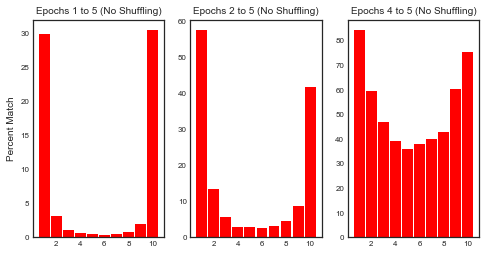

In [24]:
fr = [0, 1, 3]
to = [0, 0, 0]
names = ['1 to 5', '2 to 5', '4 to 5']

all_matches = []
for f, t in zip(fr, to):
    percent_matches = []
    for i in range(num_quantiles):
        percentile_all = []
        for j in range(f, len(percentile_splits)-t):
            percentile_all.append(percentile_splits[j][i])
        matching = reduce(np.intersect1d, percentile_all)
        percent = 100 * len(matching) / len(percentile_all[0])
        percent_matches.append(percent)
    all_matches.append(percent_matches)
    
        
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
for i, (ax, match, n) in enumerate(zip(axes, all_matches, names)):
    ax.bar(range(1, num_quantiles+1), match, width=0.9, color='r')
    if i == 0:
        ax.set_ylabel('Percent Match')
    ax.set_title('Epochs {} (No Shuffling)'.format(n))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
plt.savefig(plot_dir + "no_shuffling.jpg", format="jpg", dpi=1000, bbox_inches='tight')